In [6]:
import os
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

In [7]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BUFFER_SIZE = 200

BATCH_SIZE = 1
NEAREST_NEIGHBOR = tf.image.ResizeMethod.NEAREST_NEIGHBOR

In [8]:
# Load and process dataset images
def load_split_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    width = tf.shape(image)[1]
    width = width // 2
    input_image = image[:, :width, :]
    real_image = image[:, width:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

In [9]:
# Make sure all images have the same dimensions before feeding into the model
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, size=(height,width), method=NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, size=(height, width), method=NEAREST_NEIGHBOR)
    return input_image, real_image

In [10]:
# Data Augmentation: Random Clipping
# Random cropping can enhance data and help the model generalize better to unseen data

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image],axis=0)
    size = (2, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    cropped_image = tf.image.random_crop(stacked_image, size=size)
    input_image = cropped_image[0]
    real_image = cropped_image[1]
    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

@tf.function
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, width=286,height=286)
    input_image, real_image = random_crop(input_image,real_image)
    if np.random.uniform() > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [11]:
#load train
def load_image_train(image_file):
    input_image, real_image = load_split_image(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [12]:
#load test data
def load_image_test(image_file):
    input_image, real_image = load_split_image(image_file)
    input_image, real_image = resize(input_image, real_image,IMAGE_HEIGHT, IMAGE_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files('./dataArts/train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files('./dataArts/val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [15]:
# Build generator
# The backbone network of the generator is: U-Net. U-Net consists of an encoder (downsampler) and a decoder (upsampler).

# downsample
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

In [16]:
# upsample
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

In [17]:
# The generator takes an image, extracts feature maps using the downsampling stack, then uses the upsampling stack to transform those feature maps into an image of the same size as the original input. 
# The goal of the generator is to generate images that are as close as possible to the target images, given the input images.

def Generator():
    inputs = Input(shape=[256, 256, 3])
    down_stack = [downsample(32, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
                  downsample(64, 4),  # (batch_size, 64, 64, 128)
                  downsample(128, 4),  # (batch_size, 32, 32, 256)
                  downsample(256, 4),  # (batch_size, 16, 16, 512)
                  downsample(256, 4),  # (batch_size, 8, 8, 512)
                  #downsample(512, 4),  # (batch_size, 4, 4, 512)
                  #downsample(512, 4),  # (batch_size, 2, 2, 512)
                  #downsample(512, 4),  # (batch_size, 1, 1, 512)
                 ]

    up_stack = [#upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
                #upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
                #upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
                upsample(256, 4),  # (batch_size, 16, 16, 1024)
                upsample(128, 4),  # (batch_size, 32, 32, 512)
                upsample(64, 4),  # (batch_size, 64, 64, 256)
                upsample(32, 4),   # (batch_size, 128, 128, 128)
               ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                           kernel_initializer=initializer, activation='tanh')  # (batch_size, 256, 256, 3)
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
generator = Generator()

In [19]:
# generator loss

LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [21]:
# build discriminator
# The discriminator in cGAN is a convolutional "PatchGAN" classifier that tries to classify whether each image patch is real or not

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')
    x = concatenate([inp, tar])          # (batch_size, 256, 256, channels*2)
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)    # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)    # (batch_size, 32, 32, 256)
    zero_pad1 = ZeroPadding2D()(down3)   # (batch_size, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                  use_bias=False)(zero_pad1)                                 # (batch_size, 31, 31, 512)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding2D()(leaky_relu)                                   # (batch_size, 33, 33, 512)
    last = Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    return Model(inputs=[inp, tar], outputs=last)

In [22]:
discriminator = Discriminator()

In [23]:
# discriminator loss
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [24]:
# Optimizer and checkpoint
generator_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_opt,
                                 discriminator_optimizer=discriminator_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
#measure time
import time
import datetime
from IPython import display

In [28]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [29]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)

        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_opt.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_opt.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [30]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

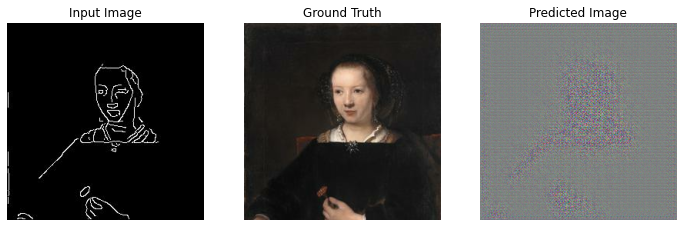

Step: 0k
...

KeyboardInterrupt: 

In [31]:
fit(train_dataset, test_dataset, steps=50000)

In [32]:
ls training_checkpoints

 驱动器 C 中的卷是 Windows-SSD
 卷的序列号是 D8D9-5A00

 C:\Users\52624\Documents\coding3\finalproject\training_checkpoints 的目录

2023/07/02  03:09    <DIR>          .
2023/07/02  03:09    <DIR>          ..
2023/07/02  03:09                69 checkpoint
2023/07/01  22:50        83,285,920 ckpt-1.data-00000-of-00001
2023/07/01  22:50             9,497 ckpt-1.index
2023/07/01  23:27        83,285,920 ckpt-2.data-00000-of-00001
2023/07/01  23:27             9,497 ckpt-2.index
2023/07/02  00:05        83,285,920 ckpt-3.data-00000-of-00001
2023/07/02  00:05             9,497 ckpt-3.index
2023/07/02  00:42        83,285,920 ckpt-4.data-00000-of-00001
2023/07/02  00:42             9,497 ckpt-4.index
2023/07/02  01:19        83,285,920 ckpt-5.data-00000-of-00001
2023/07/02  01:19             9,497 ckpt-5.index
2023/07/02  01:56        83,285,920 ckpt-6.data-00000-of-00001
2023/07/02  01:56             9,497 ckpt-6.index
2023/07/02  02:32        83,285,920 ckpt-7.data-00000-of-00001
2023/07/02  02:32        

In [33]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, size=(256, 256), method=NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    return image

(-0.5, 255.5, 255.5, -0.5)

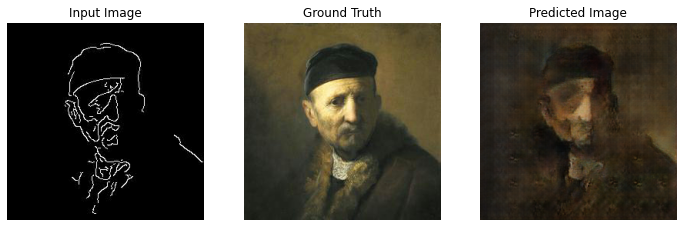

In [35]:
# show test results

test_img = load_image('./dataArts/test/293.jpg')
test_img = test_img / 127.5 - 1
test_img = tf.expand_dims(test_img, axis=0)
pred_img = generator(test_img, training=False)

ground_truth = load_image('./dataArts/test/293-t.jpg')
ground_truth = ground_truth / 127.5 - 1
ground_truth = tf.expand_dims(ground_truth, axis=0)

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_img[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(ground_truth[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Image")
plt.imshow(pred_img[0] * 0.5 + 0.5)
plt.axis('off')